In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

from transformers import ViTFeatureExtractor, ViTForImageClassification
from torchvision import transforms
import torch
from datasets import load_dataset, load_metric, ClassLabel, Features, Value
import datasets
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from typing import List, Callable, Optional

In [2]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [3]:
model_names = [name for name in os.listdir(".") if os.path.isdir(name) and "vit-dr" in name]
model_names

['vit-dr-base-lr_1e-05-cos-w-res-wd_0.01',
 'vit-dr-base-lr_3e-05-cos-w-res-wd_0.01',
 'vit-dr-sd-lr_1e-05-cos-w-res-wd_0.01',
 'vit-dr-sd-lr_3e-05-cos-w-res-wd_0.01']

In [4]:
features = Features(
    {
        "label": ClassLabel(
            num_classes=2,
            names=["no_dr", "with_dr"],
        ),
        "image": datasets.Image()
    }
)

In [11]:
""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    p = torch.nn.functional.softmax(logits, dim=1)
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}, prob: {p[0][i]}")

In [6]:
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   14, 14, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

model = ViTForImageClassification.from_pretrained(model_names[-1])
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "no_dr")),
                       ClassifierOutputTarget(category_name_to_index(model, "with_dr"))]
target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output

In [7]:
with_dr = "C:\\Users\\Admin\\Documents\\Python Scripts\\diabetic_retinopathy\\data\\preprocessed\\eval\\with_dr\\**"
with_dr = load_dataset(path="data/preprocessed", data_files={with_dr}, features=features)
no_dr = "C:\\Users\\Admin\\Documents\\Python Scripts\\diabetic_retinopathy\\data\\preprocessed\\eval\\no_dr\\**"
no_dr = load_dataset(path="data/preprocessed", data_files={no_dr}, features=features)

Resolving data files:   0%|          | 0/560 [00:00<?, ?it/s]

Using custom data configuration preprocessed-1b907d835d6558d9


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Admin/.cache/huggingface/datasets/imagefolder/preprocessed-1b907d835d6558d9/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/560 [00:00<?, ?it/s]

Using custom data configuration preprocessed-531723537902d93d


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Admin/.cache/huggingface/datasets/imagefolder/preprocessed-531723537902d93d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

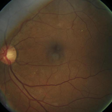

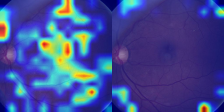

False no DR
Predicted class 0: no_dr, prob: 0.8020659685134888
Predicted class 1: with_dr, prob: 0.197934091091156


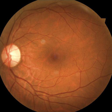

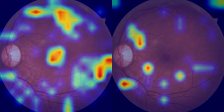

False no DR
Predicted class 0: no_dr, prob: 0.8325690031051636
Predicted class 1: with_dr, prob: 0.16743098199367523


In [12]:
# false no dr
for i in [0, 1]:
    image = with_dr["train"]["image"][i]
    img_tensor = transforms.ToTensor()(image)

    image_resized = image.resize((224, 224))
    tensor_resized = transforms.ToTensor()(image_resized)

    display(image_resized.resize((112, 112)), Image.fromarray(run_grad_cam_on_image(model=model,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))
    print("False no DR")
    print_top_categories(model, tensor_resized)

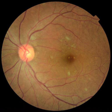

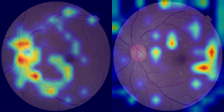

True with DR
Predicted class 1: with_dr, prob: 0.6122899055480957
Predicted class 0: no_dr, prob: 0.3877100646495819


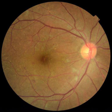

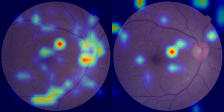

True with DR
Predicted class 1: with_dr, prob: 0.8207183480262756
Predicted class 0: no_dr, prob: 0.17928166687488556


In [13]:
# true with dr
for i in [2, 3]:
    image = with_dr["train"]["image"][i]
    img_tensor = transforms.ToTensor()(image)

    image_resized = image.resize((224, 224))
    tensor_resized = transforms.ToTensor()(image_resized)

    display(image_resized.resize((112, 112)), Image.fromarray(run_grad_cam_on_image(model=model,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))
    print("True with DR")
    print_top_categories(model, tensor_resized)

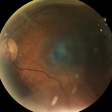

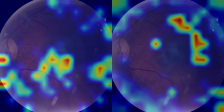

True no DR
Predicted class 0: no_dr, prob: 0.7774302959442139
Predicted class 1: with_dr, prob: 0.22256967425346375


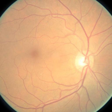

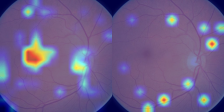

True no DR
Predicted class 0: no_dr, prob: 0.8206756114959717
Predicted class 1: with_dr, prob: 0.1793244183063507


In [14]:
# true no dr
for i in [0, 1]:
    image = no_dr["train"]["image"][i]
    img_tensor = transforms.ToTensor()(image)

    image_resized = image.resize((224, 224))
    tensor_resized = transforms.ToTensor()(image_resized)

    display(image_resized.resize((112, 112)), Image.fromarray(run_grad_cam_on_image(model=model,
                          target_layer=target_layer_gradcam,
                          targets_for_gradcam=targets_for_gradcam,
                          input_tensor=tensor_resized,
                          input_image=image_resized,
                          reshape_transform=reshape_transform_vit_huggingface)))
    print("True no DR")
    print_top_categories(model, tensor_resized)